In [25]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

with_storage_dbscan = False
with_storage_dbocsvm = False
dbscan_optuna_storage_path = "sqlite:///optuna_storage/dbscan_study.db"
ocsvm_optuna_storage_path = "sqlite:///optuna_storage/dbocsvm_study.db"

# Only need to change sample size, dataset paths, with_storage, ocsvm_trials

sample_size = 0.05
use_sample = True

use_full_train_set = True

best_model_path = "best_models/best_model_proposed.pth"

export_model = True
onnx_path = "saved_models/autoencoder.onnx"

use_existing_model = False
existing_model_path = (
    "saved_models/autoencoder_Model_1_hidden[96, 64]_latent55_best.pth"
)

existing_model_architecture = {
    "input_dim": 122,
    "hidden_dims": [96, 64],
    "latent_dim": 55,
    "activation_type": "LeakyReLU",
    "output_activation_type": "Sigmoid",
}

train_set_path = (
    "/home/jbct/Projects/thesis/db-ocsvm/data/processed/NSL-KDD/train_set_full.csv"
)
test_set_path = (
    "/home/jbct/Projects/thesis/db-ocsvm/data/processed/NSL-KDD/test_set.csv"
)

In [26]:
# model architecture if not using existing model
new_model_architecture = {
    "hidden_dims": [116, 96, 64, 48],
    "latent_dim": 22,
    "activation_type": "LeakyReLU",
    "output_activation_type": "Sigmoid",
}

new_model_learning_parameters = {
    "lr": 0.001,
    "batch_size": 128,
    "epochs": 50,
    "improvement_threshold": 0.000000001,
    "good_model_threshold": 0.00015,
    "early_stopping_patience": 10,
}

In [27]:
dbscan_tuning_parameters = {
    "evaluation_metric": "silhouette",  # silhouette, calinski_harabasz, davies_bouldin
    "distance_metric": "manhattan",  # manhattan, euclidean
    "trials": 10,
}

dbocsvm_tree_algorithm = "kd_tree"  # "ball_tree" or "kd_tree"

ocsvm_trials = 10

import dataset

In [28]:
import pandas as pd

train_df = pd.read_csv(train_set_path)

if use_sample:
    train_df = train_df.sample(frac=sample_size, random_state=42).reset_index(drop=True)

print(train_df.shape)
train_df.head(1)

(3367, 122)


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,5.833486e-07,2.572642e-07,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [29]:
from sklearn.model_selection import train_test_split

X_train_full = train_df.values

X_train, X_val = train_test_split(train_df, test_size=0.2, random_state=42)
X_train = X_train.values
X_val = X_val.values

print(X_train.shape, X_val.shape, X_train_full.shape)

(2693, 122) (674, 122) (3367, 122)


In [30]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
X_val_tensor = torch.FloatTensor(X_val)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor)
val_dataset = TensorDataset(X_val_tensor)

input_dim = X_train_full.shape[1]

training the autoencoder or use existing

In [ ]:
from models import BatchNormAutoencoder
from torch import nn, optim

if use_existing_model:
    autoencoder = BatchNormAutoencoder(
        input_dim=existing_model_architecture["input_dim"],
        hidden_dims=existing_model_architecture["hidden_dims"],
        latent_dim=existing_model_architecture["latent_dim"],
        activation_type=existing_model_architecture["activation_type"],
        output_activation_type=existing_model_architecture["output_activation_type"],
    )
else:
    # Create model
    autoencoder = BatchNormAutoencoder(
        input_dim=input_dim,
        hidden_dims=new_model_architecture["hidden_dims"],
        latent_dim=new_model_architecture["latent_dim"],
        activation_type=new_model_architecture["activation_type"],
        output_activation_type=new_model_architecture["output_activation_type"],
    )

    # loss and optimizer
    optimizer = optim.Adam(
        autoencoder.parameters(), lr=new_model_learning_parameters["lr"]
    )
    criterion = nn.MSELoss()

In [32]:
train_loader = DataLoader(
    train_dataset,
    batch_size=new_model_learning_parameters["batch_size"],
    shuffle=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=new_model_learning_parameters["batch_size"],
    shuffle=False,
)


Using device: cpu
Training autoencoder...
Epoch 1/50, Train Loss: 0.1761468947, Val Loss: 0.1269641792
✅ Model saved with val_loss: 0.1269641792
Epoch 2/50, Train Loss: 0.0696490194, Val Loss: 0.0485399812
✅ Model saved with val_loss: 0.0485399812
Epoch 3/50, Train Loss: 0.0304667127, Val Loss: 0.0206658930
✅ Model saved with val_loss: 0.0206658930
Epoch 4/50, Train Loss: 0.0185534508, Val Loss: 0.0138697834
✅ Model saved with val_loss: 0.0138697834
Epoch 5/50, Train Loss: 0.0143945384, Val Loss: 0.0110340949
✅ Model saved with val_loss: 0.0110340949
Epoch 6/50, Train Loss: 0.0113368459, Val Loss: 0.0087991237
✅ Model saved with val_loss: 0.0087991237
Epoch 7/50, Train Loss: 0.0097608249, Val Loss: 0.0075242958
✅ Model saved with val_loss: 0.0075242958
Epoch 8/50, Train Loss: 0.0092207311, Val Loss: 0.0069646700
✅ Model saved with val_loss: 0.0069646700
Epoch 9/50, Train Loss: 0.0085630535, Val Loss: 0.0062469068
✅ Model saved with val_loss: 0.0062469068
Epoch 10/50, Train Loss: 0.008

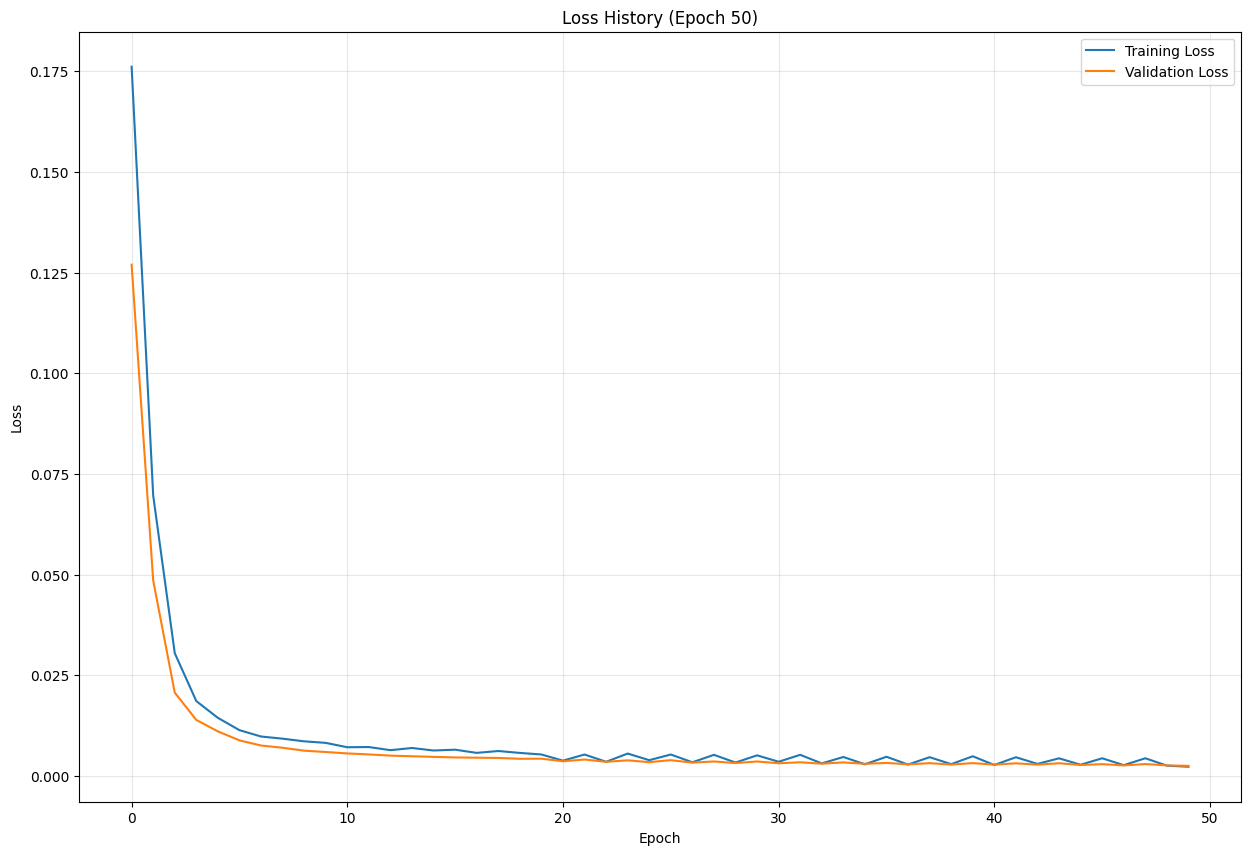

Model is bad with loss 0.0024603788818543157


In [33]:
from utils import train_autoencoder

if not use_existing_model:
    history, is_good_model = train_autoencoder(
        model=autoencoder,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        criterion=criterion,
        epochs=new_model_learning_parameters["epochs"],
        best_model_path=best_model_path,
        verbose=True,
        early_stopping_patience=new_model_learning_parameters[
            "early_stopping_patience"
        ],
        improvement_threshold=new_model_learning_parameters["improvement_threshold"],
        good_model_threshold=new_model_learning_parameters["good_model_threshold"],
        plot_results=True,
    )

In [34]:
print("Pytorch model saved at:", best_model_path)

Pytorch model saved at: best_models/best_model_proposed.pth


In [35]:
# Load best model
if use_existing_model:
    checkpoint = torch.load(existing_model_path)
    autoencoder.load_state_dict(checkpoint["model_state_dict"])
else:
    checkpoint = torch.load(best_model_path)
    autoencoder.load_state_dict(checkpoint["model_state_dict"])

autoencoder.eval()

BatchNormAutoencoderV2(
  (encoder): Sequential(
    (0): Linear(in_features=122, out_features=116, bias=True)
    (1): BatchNorm1d(116, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=116, out_features=96, bias=True)
    (5): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=96, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=64, out_features=48, bias=True)
    (13): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): LeakyReLU(negative_slope=0.2)
    (15): Dropout(p=0.2, inplace=False)
    (16): Linear(in_features=48, 

saving the model

In [36]:
import torch.onnx

if export_model and not use_existing_model:
    # Prepare a sample input tensor with the correct shape
    dummy_input = torch.randn(1, input_dim, device=device)

    torch.onnx.export(
        autoencoder,  # model being run
        dummy_input,  # model input
        onnx_path,  # where to save the model
        export_params=True,  # store trained parameters inside model file
        opset_version=17,  # ONNX version
        do_constant_folding=True,  # optimize constant folding
        input_names=["input"],  # model's input names
        output_names=["output"],  # model's output names
        dynamic_axes={
            "input": {0: "batch_size"},  # variable length axes
            "output": {0: "batch_size"},
        },
    )

    print(f"Model exported to ONNX format: {onnx_path}")

Model exported to ONNX format: saved_models/autoencoder.onnx


dbscan tuning

In [37]:
import numpy as np

# extract encoded features
X_train_full_tensor = torch.FloatTensor(X_train_full)
X_train_full_dataset = TensorDataset(X_train_full_tensor)
X_train_full_loader = DataLoader(X_train_full_dataset, batch_size=256)

# Extract in batches to prevent memory issues
if use_full_train_set:
    X_encoded = []
    with torch.no_grad():
        for data in X_train_full_loader:
            data_x = data[0].to(device)
            encoded = autoencoder.encode(data_x)
            X_encoded.append(encoded.cpu().numpy())
    X_encoded = np.vstack(X_encoded)
else:
    X_encoded = []
    with torch.no_grad():
        for data in train_loader:
            data_x = data[0].to(device)
            encoded = autoencoder.encode(data_x)
            X_encoded.append(encoded.cpu().numpy())
    X_encoded = np.vstack(X_encoded)

In [38]:
from utils import find_eps_range_with_elbow_method

input_dim_encoded = X_encoded.shape[1]

k_for_elbow = int((20 + input_dim_encoded * 2) / 2)
min_eps, max_eps = find_eps_range_with_elbow_method(
    X_encoded,
    k=k_for_elbow,
    plot=False,
)
min_eps, max_eps

(np.float64(3.0104310512542725), np.float64(12.04172420501709))

In [39]:
from utils import objective_dbscan
import optuna

dbscan_objective_lambda = lambda trial: objective_dbscan(
    trial,
    X_encoded=X_encoded,
    evaluation_metric=dbscan_tuning_parameters["evaluation_metric"],
    eps_range=(min_eps, max_eps),
    min_samples_range=(1, input_dim_encoded * 2),
    distance_metric=dbscan_tuning_parameters["distance_metric"],
    n_jobs=-1,
)

if with_storage_dbscan:
    dbscan_study = optuna.create_study(
        direction="maximize",
        storage=dbscan_optuna_storage_path,
        study_name="dbscan_study",
        load_if_exists=True,
    )
    dbscan_study.optimize(
        dbscan_objective_lambda,
        n_trials=dbscan_tuning_parameters["trials"],
    )
else:
    dbscan_study = optuna.create_study(direction="maximize")
    dbscan_study.optimize(
        dbscan_objective_lambda,
        n_trials=dbscan_tuning_parameters["trials"],
    )

[I 2025-03-08 04:36:50,049] A new study created in memory with name: no-name-5829e491-adef-4067-a6e7-f9eaf3d245a5
[I 2025-03-08 04:36:50,437] Trial 0 finished with value: 0.5257735252380371 and parameters: {'eps': 3.5338014813199083, 'min_samples': 7}. Best is trial 0 with value: 0.5257735252380371.
[I 2025-03-08 04:36:50,849] Trial 1 finished with value: 0.5507420301437378 and parameters: {'eps': 6.225904829494025, 'min_samples': 15}. Best is trial 1 with value: 0.5507420301437378.
[I 2025-03-08 04:36:51,357] Trial 2 finished with value: 0.5596916675567627 and parameters: {'eps': 11.689228833058232, 'min_samples': 26}. Best is trial 2 with value: 0.5596916675567627.
[I 2025-03-08 04:36:51,982] Trial 3 finished with value: 0.5581104755401611 and parameters: {'eps': 11.494020577742253, 'min_samples': 17}. Best is trial 2 with value: 0.5596916675567627.
[I 2025-03-08 04:36:52,256] Trial 4 finished with value: 0.6090736985206604 and parameters: {'eps': 3.5821672766474038, 'min_samples': 2

In [40]:
import pprint

# get dbscan best parameters
eps = dbscan_study.best_params["eps"]
min_samples = dbscan_study.best_params["min_samples"]

# get dbscan best trial
best_trial_dbscan = dbscan_study.best_trial
best_trial_dbscan_user_attrs = best_trial_dbscan.user_attrs

n_clusters = best_trial_dbscan_user_attrs["n_clusters"]
cluster_data_points = best_trial_dbscan_user_attrs["cluster_data_points"]

print(f"eps = {eps}")
print(f"min_samples = {min_samples}")
print(f"n_clusters = {n_clusters}")
print("cluster_data_points")
pprint.pprint(cluster_data_points)

eps = 3.5821672766474038
min_samples = 22
n_clusters = 12
cluster_data_points
{-1: 677,
 0: 160,
 1: 1668,
 2: 351,
 3: 49,
 4: 113,
 5: 79,
 6: 28,
 7: 23,
 8: 25,
 9: 125,
 10: 44,
 11: 25}


fit the DBSCAN

In [41]:
from models import DBOCSVM_V2

# Create DB-OC-SVM model with default ocsvm parameters
dbocsvm = DBOCSVM_V2(
    kernel="rbf",
    gamma="auto",
    nu=0.2,
    eps=eps,
    min_samples=min_samples,
    dbscan_metric=dbscan_tuning_parameters["distance_metric"],
    algorithm=dbocsvm_tree_algorithm,  # ball_tree, kd_tree,
)

In [42]:
dbocsvm.fit_cluster(X_encoded, verbose=True)

Fitting DBSCAN...
DBSCAN Fitted...
Unique Clusters: [-1  0  1  2  3  4  5  6  7  8  9 10 11]
Cluster Sizes: {-1: 677, 0: 160, 1: 1668, 2: 351, 3: 49, 4: 113, 5: 79, 6: 28, 7: 23, 8: 25, 9: 125, 10: 44, 11: 25}


importing test set

In [43]:
test_df = pd.read_csv(test_set_path)
print(test_df.shape)
test_df.head(1)

(22543, 125)


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,attack_binary,attack_categorical,attack_class
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,neptune,DoS


In [44]:
# Splitting into X and y
X_test = test_df.drop(
    columns=["attack_binary", "attack_categorical", "attack_class"]
).values
y_test = test_df["attack_binary"].values
y_test_class = test_df["attack_class"]

print(X_test.shape, y_test.shape)

(22543, 122) (22543,)


extract features from test data

In [45]:
X_test_tensor = torch.FloatTensor(X_test).to(device)

test_dataset = TensorDataset(X_test_tensor, torch.zeros(len(X_test_tensor)))
test_loader = DataLoader(test_dataset, batch_size=128)

X_test_encoded = []
with torch.no_grad():
    for data, _ in test_loader:
        encoded = autoencoder.encode(data)
        X_test_encoded.append(encoded.cpu().numpy())

X_test_encoded = np.vstack(X_test_encoded)
print(X_test_encoded.shape)

(22543, 22)


tuning the ocsvms

In [46]:
from utils import objective_dbocsvm_fit_ocsvm

# Inner Optuna study for DBSCAN
dbocsvm_fit_ocsvm_objective_lambda = lambda trial: objective_dbocsvm_fit_ocsvm(
    trial,
    model=dbocsvm,
    X_encoded_train=X_encoded,
    X_encoded_test=X_test_encoded,
    y_test=y_test,
    cluster_count=n_clusters,
)

if with_storage_dbocsvm:
    dbocsvm_study = optuna.create_study(
        direction="maximize",
        storage=ocsvm_optuna_storage_path,
        study_name="dbocsvm_study",
        load_if_exists=True,
    )
    dbocsvm_study.optimize(
        dbocsvm_fit_ocsvm_objective_lambda,
        n_trials=ocsvm_trials,
    )
else:
    dbocsvm_study = optuna.create_study(direction="maximize")
    dbocsvm_study.optimize(
        dbocsvm_fit_ocsvm_objective_lambda,
        n_trials=ocsvm_trials,
    )

[I 2025-03-08 04:36:55,334] A new study created in memory with name: no-name-14582076-b7e9-4bfb-8a5b-bba91df814a2
[I 2025-03-08 04:36:58,126] Trial 0 finished with value: 0.7630750121989087 and parameters: {'gamma_0': 0.017306790970474113, 'nu_0': 0.4594379151326204, 'gamma_1': 0.650875496265205, 'nu_1': 0.42273079573558964, 'gamma_2': 0.10762471696008048, 'nu_2': 0.1946742106476493, 'gamma_3': 0.8238253588350257, 'nu_3': 0.19751680339040156, 'gamma_4': 0.5577982007098046, 'nu_4': 0.3637516611359019, 'gamma_5': 0.8848628903597172, 'nu_5': 0.35953978791484525, 'gamma_6': 0.08775026811526096, 'nu_6': 0.015716180991930794, 'gamma_7': 0.4695508900054048, 'nu_7': 0.21607761008027554, 'gamma_8': 0.016806737609846033, 'nu_8': 0.09047259288585588, 'gamma_9': 0.49778242919190024, 'nu_9': 0.20870529536600155, 'gamma_10': 0.29405583259373924, 'nu_10': 0.19182816210849957, 'gamma_11': 0.6934105551162736, 'nu_11': 0.10100119933634831}. Best is trial 0 with value: 0.7630750121989087.
[I 2025-03-08 0

In [47]:
parameter_list = {}

for key, value in dbocsvm_study.best_params.items():
    cluster = key.split("_")[1]
    cluster = int(cluster)

    parameter_list[cluster] = {
        "kernel": "rbf",
        "gamma": dbocsvm_study.best_params[f"gamma_{cluster}"],
        "nu": dbocsvm_study.best_params[f"nu_{cluster}"],
    }

best parameters and values

In [48]:
if use_existing_model:
    autoencoder_architecture = {
        "input_dim": existing_model_architecture["input_dim"],
        "hidden_dims": existing_model_architecture["hidden_dims"],
        "latent_dim": existing_model_architecture["latent_dim"],
        "activation_type": existing_model_architecture["activation_type"],
        "output_activation_type": existing_model_architecture["output_activation_type"],
        "val_loss": checkpoint["val_loss"],
    }
else:
    autoencoder_architecture = {
        "input_dim": input_dim,
        "hidden_dims": new_model_architecture["hidden_dims"],
        "latent_dim": new_model_architecture["latent_dim"],
        "activation_type": new_model_architecture["activation_type"],
        "output_activation_type": new_model_architecture["output_activation_type"],
        "learning_rate": new_model_learning_parameters["lr"],
        "batch_size": new_model_learning_parameters["batch_size"],
        "epochs": new_model_learning_parameters["epochs"],
        "improvement_threshold": new_model_learning_parameters["improvement_threshold"],
        "good_model_threshold": new_model_learning_parameters["good_model_threshold"],
        "early_stopping_patience": new_model_learning_parameters[
            "early_stopping_patience"
        ],
        "val_loss": checkpoint["val_loss"],
    }

print("Best autoencoder model:")
pprint.pprint(autoencoder_architecture, sort_dicts=False)
print("")

best_dbscan_parameters = {
    "eps": eps,
    "min_samples": min_samples,
    "distance_metric": dbscan_tuning_parameters["distance_metric"],
    "evaluation_metric": dbscan_tuning_parameters["evaluation_metric"],
    "score": best_trial_dbscan.value,
}

print("Best dbscan parameters")
pprint.pprint(best_dbscan_parameters, sort_dicts=False)
print("")

print("Best ocsvm parameters")
print(f"Tree algorithm: {dbocsvm_tree_algorithm}")
print(f"Accuracy: {dbocsvm_study.best_value}")
pprint.pprint(parameter_list, sort_dicts=False)

Best autoencoder model:
{'input_dim': 122,
 'hidden_dims': [116, 96, 64, 48],
 'latent_dim': 22,
 'activation_type': 'LeakyReLU',
 'output_activation_type': 'Sigmoid',
 'learning_rate': 0.001,
 'batch_size': 128,
 'epochs': 50,
 'improvement_threshold': 1e-09,
 'good_model_threshold': 0.00015,
 'early_stopping_patience': 10,
 'val_loss': 0.0024603788818543157}

Best dbscan parameters
{'eps': 3.5821672766474038,
 'min_samples': 22,
 'distance_metric': 'manhattan',
 'evaluation_metric': 'silhouette',
 'score': 0.6090736985206604}

Best ocsvm parameters
Tree algorithm: kd_tree
Accuracy: 0.8658120037262121
{0: {'kernel': 'rbf', 'gamma': 0.5489972536306758, 'nu': 0.43669512527094123},
 1: {'kernel': 'rbf', 'gamma': 0.6475839689582553, 'nu': 0.020021354395165593},
 2: {'kernel': 'rbf', 'gamma': 0.5754992314287082, 'nu': 0.1193955581014561},
 3: {'kernel': 'rbf', 'gamma': 0.5043013531468987, 'nu': 0.19251709928896177},
 4: {'kernel': 'rbf', 'gamma': 0.9512741655529502, 'nu': 0.095757546703163